In [3]:
from google.colab import files
files.download("jira_issues_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd

df = pd.read_csv("jira_issues_cleaned.csv")
df.head()

,input_text,priority_level
0,fail work add bucket setting fail test run ent...,Low
1,abfs fnsoverblob Page issue Subsequent ListBlo...,Medium
2,improve performance patch similar add normaliz...,Medium
3,Upgrade libxxhash Windows current version libx...,Medium
4,stream write close fail badly FS close close p...,Low


In [5]:
# prompt: Using dataframe df: total number of issues

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17257 entries, 0 to 17256
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   input_text      17257 non-null  object
 1   priority_level  17257 non-null  object
dtypes: object(2)
memory usage: 269.8+ KB


In [6]:
X = df["input_text"]
y = df["priority_level"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary size
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words="english" # filter English stopwords
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Naive bias

In [7]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_vec, y_train)
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.54      0.02      0.04       359
         Low       0.62      0.08      0.14       865
      Medium       0.66      0.98      0.79      2228

    accuracy                           0.65      3452
   macro avg       0.61      0.36      0.32      3452
weighted avg       0.64      0.65      0.55      3452



# LINEAR SVM

In [8]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight="balanced")
svm_model.fit(X_train_vec, y_train)

LinearSVC(class_weight='balanced')

In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_vec, y_train)

              precision    recall  f1-score   support

        High       0.54      0.02      0.04       359
         Low       0.62      0.08      0.14       865
      Medium       0.66      0.98      0.79      2228

    accuracy                           0.65      3452
   macro avg       0.61      0.36      0.32      3452
weighted avg       0.64      0.65      0.55      3452



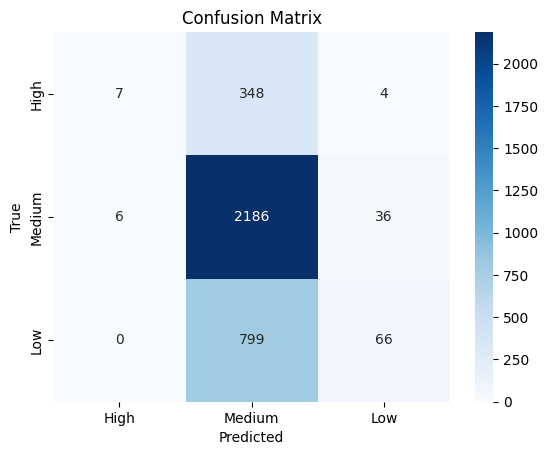

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Re-predict and evaluate
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["High", "Medium", "Low"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["High", "Medium", "Low"], yticklabels=["High", "Medium", "Low"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# GRID SEARCH ON LINEARSVM

In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define model with class balancing
svc = LinearSVC(class_weight='balanced', max_iter=5000)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10]  # regularization strength
}

# Wrap in GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Fit on training vectors (optionally SMOTE balanced)
grid_search.fit(X_train_vec, y_train)

# Best model
best_svc = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = best_svc.predict(X_test_vec)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 0.1}
              precision    recall  f1-score   support

        High       0.27      0.27      0.27       359
         Low       0.48      0.38      0.42       865
      Medium       0.70      0.76      0.73      2228

    accuracy                           0.62      3452
   macro avg       0.49      0.47      0.48      3452
weighted avg       0.60      0.62      0.61      3452



In [12]:
import joblib

joblib.dump(model, "priority_classifier_final.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_final.pkl")

['tfidf_vectorizer_final.pkl']

# RANDOM FOREST

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your cleaned dataset
df = pd.read_csv("jira_issues_cleaned.csv")
X = df["input_text"].astype(str)
y = df["priority_level"]

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, stratify=y, test_size=0.2, random_state=42)

In [14]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("📘 Random Forest Evaluation")
print(classification_report(y_test, y_pred_rf))

📘 Random Forest Evaluation
              precision    recall  f1-score   support

        High       0.38      0.01      0.02       359
         Low       0.61      0.15      0.24       865
      Medium       0.66      0.96      0.79      2228

    accuracy                           0.66      3452
   macro avg       0.55      0.37      0.35      3452
weighted avg       0.62      0.66      0.57      3452



In [15]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    rf, param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("✅ Best Parameters:", grid.best_params_)
print("📊 Tuned RF Evaluation")
print(classification_report(y_test, y_pred_best_rf))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
📊 Tuned RF Evaluation
              precision    recall  f1-score   support

        High       0.26      0.18      0.21       359
         Low       0.43      0.46      0.45       865
      Medium       0.71      0.73      0.72      2228

    accuracy                           0.60      3452
   macro avg       0.47      0.45      0.46      3452
weighted avg       0.59      0.60      0.60      3452




📊 Final Random Forest Evaluation Report
              precision    recall  f1-score   support

        High       0.26      0.18      0.21       359
         Low       0.43      0.46      0.45       865
      Medium       0.71      0.73      0.72      2228

    accuracy                           0.60      3452
   macro avg       0.47      0.45      0.46      3452
weighted avg       0.59      0.60      0.60      3452



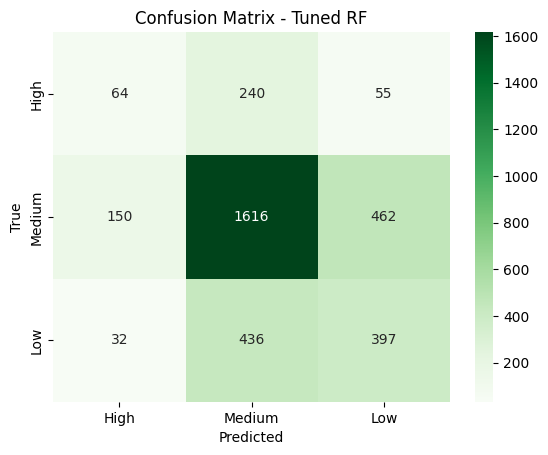

📝 Task: Fix critical bug in HDFS namenode replication
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Improve UI documentation for Apache Hadoop
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Upgrade to Java 17 for compatibility
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Implement backup policy for configuration files
➡️ Predicted Priority: Medium
------------------------------------------------------------

🎉 Model, vectorizer, and predictions exported successfully!


In [18]:

# ✅ 1. Ensure directory exists
import os
import joblib
os.makedirs("model", exist_ok=True)

# ✅ 2. Save tuned Random Forest model
joblib.dump(best_rf, 'model/final_classifier_rf.joblib')

# ✅ 3. Save TF-IDF vectorizer
joblib.dump(vectorizer, 'model/tfidf_vectorizer.joblib')

# ✅ 4. Visualize Confusion Matrix and Evaluation Report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict again to confirm
y_pred = best_rf.predict(X_test)

# Print classification metrics
print("\n\U0001F4CA Final Random Forest Evaluation Report")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["High", "Medium", "Low"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["High", "Medium", "Low"], yticklabels=["High", "Medium", "Low"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Tuned RF")
plt.show()

# ✅ 5. Generate Prediction Summary Report
import pandas as pd

# Create prediction report DataFrame
summary_df = pd.DataFrame({
    'Text': X_test,  # if X_test is array-like of text. Else join with original df
    'Actual': y_test,
    'Predicted': y_pred
})
summary_df.to_csv("model/prediction_summary_rf.csv", index=False)

import joblib

# Load the trained classifier and vectorizer
model = joblib.load("/content/priority_classifier_final.pkl")
vectorizer = joblib.load("/content/tfidf_vectorizer_final.pkl")

# Example tasks to classify
sample_tasks = [
    "Fix critical bug in HDFS namenode replication",
    "Improve UI documentation for Apache Hadoop",
    "Upgrade to Java 17 for compatibility",
    "Implement backup policy for configuration files"
]

# Vectorize the input tasks
X_new = vectorizer.transform(sample_tasks)

# Predict priorities
predicted_priorities = model.predict(X_new)

# Display results
for task, priority in zip(sample_tasks, predicted_priorities):
    print(f"📝 Task: {task}\n➡️ Predicted Priority: {priority}\n{'-'*60}")

print("\n\U0001F389 Model, vectorizer, and predictions exported successfully!")


In [19]:
# ✅ 6. Optional: Export from Colab (uncomment if needed)
from google.colab import files
files.download("model/final_classifier_rf.joblib")
files.download("model/tfidf_vectorizer.joblib")
files.download("model/prediction_summary_rf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import joblib

# Load the trained classifier and vectorizer
model = joblib.load("/content/priority_classifier_final.pkl")
vectorizer = joblib.load("/content/tfidf_vectorizer_final.pkl")

# Example tasks to classify
sample_tasks = [
    "Fix critical bug in HDFS namenode replication",
    "Improve UI documentation for Apache Hadoop",
    "Upgrade to Java 17 for compatibility",
    "Implement backup policy for configuration files"
]

# Vectorize the input tasks
X_new = vectorizer.transform(sample_tasks)

# Predict priorities
predicted_priorities = model.predict(X_new)

# Display results
for task, priority in zip(sample_tasks, predicted_priorities):
    print(f"📝 Task: {task}\n➡️ Predicted Priority: {priority}\n{'-'*60}")

📝 Task: Fix critical bug in HDFS namenode replication
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Improve UI documentation for Apache Hadoop
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Upgrade to Java 17 for compatibility
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Implement backup policy for configuration files
➡️ Predicted Priority: Medium
------------------------------------------------------------


In [21]:
# app.py
!pip install streamlit
import streamlit as st
import joblib

model = joblib.load('/content/priority_classifier_final.pkl')
vectorizer = joblib.load("/content/tfidf_vectorizer_final.pkl")

st.title("AI-Powered Task Priority Predictor")

task_input = st.text_area("Enter task description:")
if st.button("Predict Priority"):
    if task_input:
        vec = vectorizer.transform([task_input])
        prediction = model.predict(vec)[0]
        st.success(f"Predicted Priority: **{prediction}**")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


2025-05-27 08:48:56.972 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 08:48:57.077 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-27 08:48:57.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 08:48:57.081 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 08:48:57.086 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 08:48:57.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 08:48:57.091 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 08:48:57.092 Session state does not 

In [22]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.9 MB/s eta 0:00:00


In [23]:
"""
import gradio as gr
import joblib

# Load model and vectorizer
model = joblib.load("/content/priority_classifier_final.pkl")
vectorizer = joblib.load("/content/tfidf_vectorizer_final.pkl")

# Define prediction function
def classify_priority(task_text):
    X = vectorizer.transform([task_text])
    prediction = model.predict(X)[0]
    return f"Predicted Priority: {prediction}"

# Create Gradio interface
gr.Interface(
    fn=classify_priority,
    inputs=gr.Textbox(label="Enter Task Description"),
    outputs=gr.Textbox(label="Predicted Priority"),
    title="AI Task Prioritizer (Random Forest)",
    theme="default"
).launch(share=True)  # share=True gives a public link
"""

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()


KeyboardInterrupt: 

In [24]:
# 1. Install nbconvert
!pip install --quiet nbconvert pyppeteer

# 2. Execute the notebook and convert to HTML
!jupyter nbconvert --to html --execute \
    --output executed_notebook.html "AI TASK deployement version.ipynb"

# 3. Convert the same notebook to PDF
!jupyter nbconvert --to pdf \
    --output executed_notebook.pdf "AI TASK deployement version.ipynb"

# 4. Download the results
from google.colab import files
files.download('executed_notebook.html')
files.download('executed_notebook.pdf')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.7.3 requires websockets>=14.0, but you have websockets 10.4 which is incompatible.
google-genai 1.15.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 10.4 which is incompatible.
yfinance 0.2.61 requires websockets>=13.0, but you have websockets 10.4 which is incompatible.
[NbConvertApp] WARNING | pattern 'AI TASK deployement version.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The 

FileNotFoundError: Cannot find file: executed_notebook.html